In [1]:
# ML libraries and modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt1
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
le = preprocessing.LabelEncoder()
warnings.filterwarnings('ignore')


import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  #Prediction error metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from datetime import date
from pathlib import Path
import pickle
from collections import OrderedDict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

#nlargest for confirmed cases in each country
from heapq import nlargest
from operator import itemgetter


In [2]:
#mount google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab Notebooks

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [15]:
#put data in to test, train, and submission dataframes
test = pd.read_csv('MLProjectFiles/test.csv',delimiter=',',error_bad_lines=False)
train = pd.read_csv('MLProjectFiles/train.csv',delimiter=',',error_bad_lines=False)
submission = pd.read_csv('MLProjectFiles/submission.csv',delimiter=',',error_bad_lines=False)
world_population = pd.read_csv('MLProjectFiles/population_by_country_2020.csv',delimiter=',',error_bad_lines=False)

In [346]:
world_population

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1382345085,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,331341050,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,274021604,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,221612785,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %
...,...,...,...,...,...,...,...,...,...,...,...
230,Montserrat,4993,0.06 %,3,50,100,NaN,N.A.,N.A.,10 %,0.00 %
231,Falkland Islands,3497,3.05 %,103,0,12170,NaN,N.A.,N.A.,66 %,0.00 %
232,Niue,1628,0.68 %,11,6,260,NaN,N.A.,N.A.,46 %,0.00 %
233,Tokelau,1360,1.27 %,17,136,10,NaN,N.A.,N.A.,0 %,0.00 %


In [16]:
#fill na values 
train.Province_State.fillna("None", inplace=True)
train.head()


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


In [245]:
#use describe to get better understanding of dataset
train.describe()

,Id,ConfirmedCases,Fatalities
count,35995.000000,35995.000000,35995.000000
mean,17998.000000,3683.508737,243.560217
std,10391.005806,18986.978708,1832.966999
min,1.000000,0.000000,0.000000
25%,8999.500000,0.000000,0.000000
50%,17998.000000,19.000000,0.000000
75%,26996.500000,543.000000,7.000000
max,35995.000000,345813.000000,33998.000000


In [246]:
#find the total number of days, range of dates, and countries with province states
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())

Number of Country_Region:  184
Dates go from day 2020-05-15 to day 2020-01-22 , a total of 115 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [248]:
#Find the GLOBAL total number of confirmed cases and fatalities 
confirmed_cases_total = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total = train.groupby(['Date']).agg({'Fatalities':['sum']})
cases_date_original = confirmed_cases_total.join(fatalities_total)
cases_date_original

,ConfirmedCases,Fatalities
,sum,sum
Date,,
2020-01-22,554.0,17.0
2020-01-23,653.0,18.0
2020-01-24,939.0,26.0
2020-01-25,1432.0,42.0
2020-01-26,2113.0,56.0
...,...,...
2020-05-11,4176589.0,286293.0
2020-05-12,4260955.0,291924.0


In [249]:
#Analyze transmission behavior in China because it was the initially infected country
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

Text(0.5, 0, 'Date')

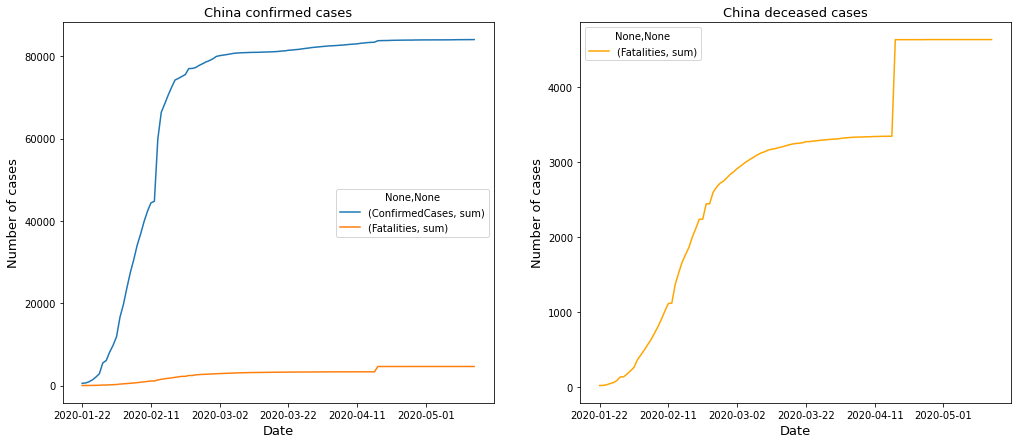

In [250]:
#plot China total confirmed cases and deceased cases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

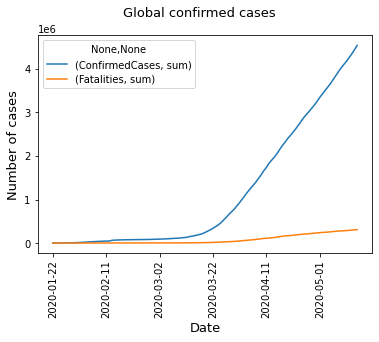

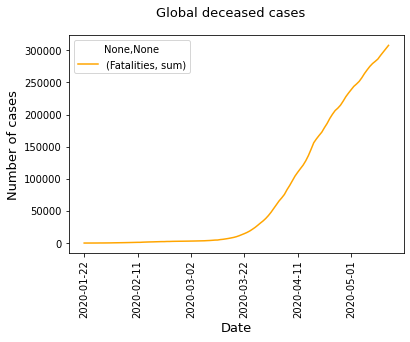

In [251]:
#plot the global number of confirmed cases and fatalities
cases_date.plot()
plt.xticks(rotation='vertical')
plt.suptitle("Global confirmed cases", size=13)
plt.ylabel("Number of cases", size=13)
plt.xlabel("Date", size=13)
fatalities_total.plot(color='orange')
plt.suptitle("Global deceased cases", size=13)
plt.ylabel("Number of cases", size=13)
plt.xlabel("Date", size=13)
plt.xticks(rotation='vertical')

In [277]:
#create 1d arrays with the total amount of confirmed cases and fatalities by country
total_confirmed_countries = train.groupby(['Country_Region']).agg({'ConfirmedCases':['sum']})
total_confirmed_countries = np.array(total_confirmed_countries)
total_confirmed_countries = total_confirmed_countries.flatten()

total_fatalities_countries = train.groupby(['Country_Region']).agg({'Fatalities':['sum']})
total_fatalities_countries = np.array(total_fatalities_countries)
total_fatalities_countries = total_fatalities_countries.flatten()
total_confirmed_countries


array([8.7824000e+04, 3.0543000e+04, 1.5484500e+05, 3.3193000e+04,
       1.2540000e+03, 1.0530000e+03, 1.7034100e+05, 8.6278000e+04,
       3.2808000e+05, 7.3894100e+05, 7.2455000e+04, 3.0280000e+03,
       1.2535400e+05, 2.7319000e+05, 3.5730000e+03, 4.6841900e+05,
       1.8619090e+06, 6.9900000e+02, 4.4400000e+03, 3.5900000e+02,
       5.0377000e+04, 6.6808000e+04, 7.9400000e+02, 3.2902800e+06,
       7.8750000e+03, 5.7174000e+04, 2.8014000e+04, 5.0180000e+03,
       4.0600000e+02, 4.8500000e+03, 6.6720000e+03, 6.7647000e+04,
       1.9868790e+06, 2.3610000e+03, 4.6310000e+03, 6.8237500e+05,
       7.9467950e+06, 2.6086400e+05, 7.8060000e+03, 2.2980000e+04,
       3.2511000e+04, 4.6517000e+04, 8.8377000e+04, 5.2368000e+04,
       3.5259000e+04, 3.3069600e+05, 3.9123800e+05, 6.4084000e+04,
       3.4100000e+04, 7.7900000e+02, 2.6490300e+05, 7.8674000e+05,
       2.1784500e+05, 1.7049000e+04, 9.3440000e+03, 1.6770000e+03,
       7.4327000e+04, 3.1720000e+03, 5.7760000e+03, 7.8100000e

In [288]:
#Create a data frame containing the total number of fatalities and confirmed cases for each country to find hotspots
df_countries = pd.DataFrame()
df_countries['Confirmed Cases'] = total_confirmed_countries
df_countries['Fatalities'] = total_fatalities_countries
df_countries['Country']=train.Country_Region.unique()
df_countries

,Confirmed Cases,Fatalities,Country
0,87824.0,2523.0,Afghanistan
1,30543.0,1284.0,Albania
2,154845.0,16883.0,Algeria
3,33193.0,1658.0,Andorra
4,1254.0,96.0,Angola
...,...,...,...
179,14974.0,0.0,Vietnam
180,15493.0,87.0,West Bank and Gaza
181,232.0,0.0,Western Sahara
182,6022.0,138.0,Zambia


In [294]:
#Identify top 6 countries with highest confirmed cases of COVID
df_countries.nlargest(6, 'Confirmed Cases')

,Confirmed Cases,Fatalities,Country
171,39749076.0,2122579.0,US
84,9386990.0,1211456.0,Italy
156,9322515.0,995560.0,Spain
36,7946795.0,333639.0,China
65,7080489.0,229882.0,Germany
61,6749906.0,899572.0,France


In [293]:
#Identify top 6 countries with highest fatalities from COVID
df_countries.nlargest(6, 'Fatalities')

,Confirmed Cases,Fatalities,Country
171,39749076.0,2122579.0,US
84,9386990.0,1211456.0,Italy
156,9322515.0,995560.0,Spain
175,6360259.0,933303.0,United Kingdom
61,6749906.0,899572.0,France
36,7946795.0,333639.0,China


In [300]:
#Plot the top 7 countries with highest fatalities and confirmed cases
confirmed_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

confirmed_total_date_Germany = train[train['Country_Region']=='Germany'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Germany = train[train['Country_Region']=='Germany'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Germany = confirmed_total_date_Germany.join(fatalities_total_date_Germany)

confirmed_total_date_US = train[train['Country_Region']=='US'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_US = train[train['Country_Region']=='US'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_US = confirmed_total_date_US.join(fatalities_total_date_US)

confirmed_total_date_France = train[train['Country_Region']=='France'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_France = train[train['Country_Region']=='France'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_France = confirmed_total_date_France.join(fatalities_total_date_France)

confirmed_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)



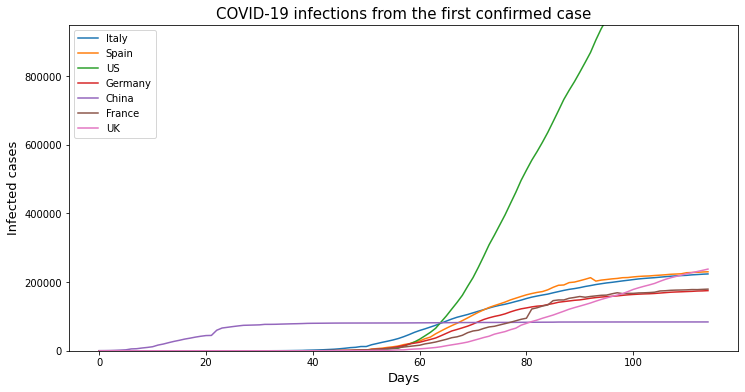

In [301]:
italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:70] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:70] 
US = [i for i in total_date_US.ConfirmedCases['sum'].values]
US_30 = US[0:70] 
germany = [i for i in total_date_Germany.ConfirmedCases['sum'].values]
germany_30 = germany[0:70] 
china = [i for i in total_date_China.ConfirmedCases['sum'].values]
china_30 = china[0:70]
france = [i for i in total_date_France.ConfirmedCases['sum'].values]
france_30 = france[0:70]
uk = [i for i in total_date_UK.ConfirmedCases['sum'].values]
uk_30 = france[0:70]

# Plots
plt.figure(figsize=(12,6))
plt.plot(italy)
plt.plot(spain)
plt.plot(US)
plt.plot(germany)
plt.plot(china)
plt.plot(france)
plt.plot(uk)
plt.legend(["Italy", "Spain", "US", "Germany","China","France","UK"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 950000)
plt.show()

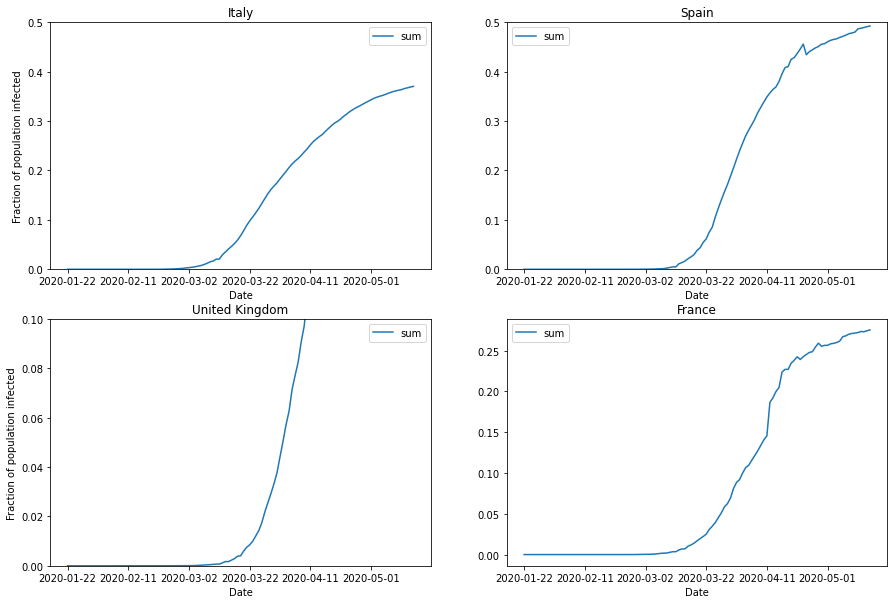

In [302]:
#Find fraction of population that has been infected overtime and plot the results
pop_italy = 60486683
pop_spain = 46749696
pop_US = 330566068
pop_Germany = 5837230
pop_UK = 67784927
pop_France = 65273511
total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_France.ConfirmedCases = total_date_France.ConfirmedCases/pop_France*100.
total_date_France.Fatalities = total_date_France.ConfirmedCases/pop_France*100.
total_date_Germany.ConfirmedCases = total_date_Germany.ConfirmedCases/pop_Germany*100.
total_date_Germany.Fatalities = total_date_Germany.ConfirmedCases/pop_Germany*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.5)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.5)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.1)

plt.subplot(2, 2, 4)
total_date_France.ConfirmedCases.plot(ax=plt.gca(), title='France')


###Data Preprocessing


In [303]:
#create a dictionary with all countries and their respective country region number
dict_country = dict(zip(train_cleaned.Country_Region,train_cleaned.country_region_number))
dict_province = dict(zip(train_cleaned.Province_State,train_cleaned.province_state_number))

In [17]:
#clean up null values inside train df create a number for each day, country, and province
#fill null values with appropriate values
train_cleaned = train
le = LabelEncoder()
train_cleaned['day_number'] = le.fit_transform(train_cleaned.Date)
train_cleaned['country_region_number'] = le.fit_transform(train_cleaned.Country_Region)
train_cleaned['province_state_number'] = le.fit_transform(train_cleaned.Province_State)
train_cleaned['Province_State'].fillna("None", inplace=True)
train_cleaned['ConfirmedCases'].fillna(0, inplace=True)
train_cleaned['Fatalities'].fillna(0, inplace=True)
train_cleaned

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number
0,1,None,Afghanistan,2020-01-22,0.0,0.0,0,0,83
1,2,None,Afghanistan,2020-01-23,0.0,0.0,1,0,83
2,3,None,Afghanistan,2020-01-24,0.0,0.0,2,0,83
3,4,None,Afghanistan,2020-01-25,0.0,0.0,3,0,83
4,5,None,Afghanistan,2020-01-26,0.0,0.0,4,0,83
...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,36.0,4.0,110,183,83
35991,35992,None,Zimbabwe,2020-05-12,36.0,4.0,111,183,83
35992,35993,None,Zimbabwe,2020-05-13,37.0,4.0,112,183,83
35993,35994,None,Zimbabwe,2020-05-14,37.0,4.0,113,183,83


In [18]:
#create country_province column
train_cleaned['country_province'] = train_cleaned['Country_Region'] +','+ train_cleaned['Province_State']
train_cleaned

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,country_province
0,1,None,Afghanistan,2020-01-22,0.0,0.0,0,0,83,"Afghanistan,None"
1,2,None,Afghanistan,2020-01-23,0.0,0.0,1,0,83,"Afghanistan,None"
2,3,None,Afghanistan,2020-01-24,0.0,0.0,2,0,83,"Afghanistan,None"
3,4,None,Afghanistan,2020-01-25,0.0,0.0,3,0,83,"Afghanistan,None"
4,5,None,Afghanistan,2020-01-26,0.0,0.0,4,0,83,"Afghanistan,None"
...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,36.0,4.0,110,183,83,"Zimbabwe,None"
35991,35992,None,Zimbabwe,2020-05-12,36.0,4.0,111,183,83,"Zimbabwe,None"
35992,35993,None,Zimbabwe,2020-05-13,37.0,4.0,112,183,83,"Zimbabwe,None"
35993,35994,None,Zimbabwe,2020-05-14,37.0,4.0,113,183,83,"Zimbabwe,None"


In [19]:
#this function creates lags for the past 7 days to use for models
def generate_lag(dframe, by, target, periods):
    #print("Generating laged values for", target)
    for num in range(1, periods+1):
        dframe[target+'_lag'+str(num)]=dframe.groupby(by)[target].shift(num)
        dframe[target+'_lag'+str(num)].fillna(0, inplace=True)
    return dframe

lags = generate_lag(train_cleaned,'country_province','ConfirmedCases',7)
lags

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,country_province,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7
0,1,None,Afghanistan,2020-01-22,0.0,0.0,0,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0,1,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0,2,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0,3,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0,4,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,36.0,4.0,110,183,83,"Zimbabwe,None",36.0,35.0,34.0,34.0,34.0,34.0,34.0
35991,35992,None,Zimbabwe,2020-05-12,36.0,4.0,111,183,83,"Zimbabwe,None",36.0,36.0,35.0,34.0,34.0,34.0,34.0
35992,35993,None,Zimbabwe,2020-05-13,37.0,4.0,112,183,83,"Zimbabwe,None",36.0,36.0,36.0,35.0,34.0,34.0,34.0
35993,35994,None,Zimbabwe,2020-05-14,37.0,4.0,113,183,83,"Zimbabwe,None",37.0,36.0,36.0,36.0,35.0,34.0,34.0


In [20]:
#check train_cleaned values after adding lags
train_cleaned

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,country_province,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7
0,1,None,Afghanistan,2020-01-22,0.0,0.0,0,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0,1,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0,2,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0,3,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0,4,0,83,"Afghanistan,None",0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,36.0,4.0,110,183,83,"Zimbabwe,None",36.0,35.0,34.0,34.0,34.0,34.0,34.0
35991,35992,None,Zimbabwe,2020-05-12,36.0,4.0,111,183,83,"Zimbabwe,None",36.0,36.0,35.0,34.0,34.0,34.0,34.0
35992,35993,None,Zimbabwe,2020-05-13,37.0,4.0,112,183,83,"Zimbabwe,None",36.0,36.0,36.0,35.0,34.0,34.0,34.0
35993,35994,None,Zimbabwe,2020-05-14,37.0,4.0,113,183,83,"Zimbabwe,None",37.0,36.0,36.0,36.0,35.0,34.0,34.0


In [9]:
#check for null values
train_cleaned.country_province.isna().sum()

0

In [21]:
#one hot encode all of the countries within the dataset
dframe=pd.get_dummies(train_cleaned, columns=['country_province'], prefix='cp', sparse=False)
dframe

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7,"cp_Afghanistan,None","cp_Albania,None","cp_Algeria,None","cp_Andorra,None","cp_Angola,None","cp_Antigua and Barbuda,None","cp_Argentina,None","cp_Armenia,None","cp_Australia,Australian Capital Territory","cp_Australia,New South Wales","cp_Australia,Northern Territory","cp_Australia,Queensland","cp_Australia,South Australia","cp_Australia,Tasmania","cp_Australia,Victoria","cp_Australia,Western Australia","cp_Austria,None","cp_Azerbaijan,None","cp_Bahamas,None","cp_Bahrain,None","cp_Bangladesh,None","cp_Barbados,None","cp_Belarus,None","cp_Belgium,None",...,"cp_US,Ohio","cp_US,Oklahoma","cp_US,Oregon","cp_US,Pennsylvania","cp_US,Puerto Rico","cp_US,Rhode Island","cp_US,South Carolina","cp_US,South Dakota","cp_US,Tennessee","cp_US,Texas","cp_US,Utah","cp_US,Vermont","cp_US,Virgin Islands","cp_US,Virginia","cp_US,Washington","cp_US,West Virginia","cp_US,Wisconsin","cp_US,Wyoming","cp_Uganda,None","cp_Ukraine,None","cp_United Arab Emirates,None","cp_United Kingdom,Anguilla","cp_United Kingdom,Bermuda","cp_United Kingdom,British Virgin Islands","cp_United Kingdom,Cayman Islands","cp_United Kingdom,Channel Islands","cp_United Kingdom,Falkland Islands (Malvinas)","cp_United Kingdom,Gibraltar","cp_United Kingdom,Isle of Man","cp_United Kingdom,Montserrat","cp_United Kingdom,None","cp_United Kingdom,Turks and Caicos Islands","cp_Uruguay,None","cp_Uzbekistan,None","cp_Venezuela,None","cp_Vietnam,None","cp_West Bank and Gaza,None","cp_Western Sahara,None","cp_Zambia,None","cp_Zimbabwe,None"
0,1,None,Afghanistan,2020-01-22,0.0,0.0,0,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,None,Afghanistan,2020-01-23,0.0,0.0,1,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,None,Afghanistan,2020-01-24,0.0,0.0,2,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,None,Afghanistan,2020-01-25,0.0,0.0,3,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,None,Afghanistan,2020-01-26,0.0,0.0,4,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,36.0,4.0,110,183,83,36.0,35.0,34.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
35991,35992,None,Zimbabwe,2020-05-12,36.0,4.0,111,183,83,36.0,36.0,35.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
35992,35993,None,Zimbabwe,2020-05-13,37.0,4.0,112,183,83,36.0,36.0,36.0,35.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
35993,35994,None,Zimbabwe,2020-05-14,37.0,4.0,113,183,83,37.0,36.0,36.0,36.0,35.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [22]:
#update train cleaned
train_cleaned = dframe

In [23]:
#this function calculates trends for the past 7 days 
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df
trends = calculate_trend(train_cleaned, range(1,8), 'ConfirmedCases')
trends

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7,"cp_Afghanistan,None","cp_Albania,None","cp_Algeria,None","cp_Andorra,None","cp_Angola,None","cp_Antigua and Barbuda,None","cp_Argentina,None","cp_Armenia,None","cp_Australia,Australian Capital Territory","cp_Australia,New South Wales","cp_Australia,Northern Territory","cp_Australia,Queensland","cp_Australia,South Australia","cp_Australia,Tasmania","cp_Australia,Victoria","cp_Australia,Western Australia","cp_Austria,None","cp_Azerbaijan,None","cp_Bahamas,None","cp_Bahrain,None","cp_Bangladesh,None","cp_Barbados,None","cp_Belarus,None","cp_Belgium,None",...,"cp_US,South Dakota","cp_US,Tennessee","cp_US,Texas","cp_US,Utah","cp_US,Vermont","cp_US,Virgin Islands","cp_US,Virginia","cp_US,Washington","cp_US,West Virginia","cp_US,Wisconsin","cp_US,Wyoming","cp_Uganda,None","cp_Ukraine,None","cp_United Arab Emirates,None","cp_United Kingdom,Anguilla","cp_United Kingdom,Bermuda","cp_United Kingdom,British Virgin Islands","cp_United Kingdom,Cayman Islands","cp_United Kingdom,Channel Islands","cp_United Kingdom,Falkland Islands (Malvinas)","cp_United Kingdom,Gibraltar","cp_United Kingdom,Isle of Man","cp_United Kingdom,Montserrat","cp_United Kingdom,None","cp_United Kingdom,Turks and Caicos Islands","cp_Uruguay,None","cp_Uzbekistan,None","cp_Venezuela,None","cp_Vietnam,None","cp_West Bank and Gaza,None","cp_Western Sahara,None","cp_Zambia,None","cp_Zimbabwe,None",Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_ConfirmedCases_7
0,1,None,Afghanistan,2020-01-22,0.0,0.0,0,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,None,Afghanistan,2020-01-23,0.0,0.0,1,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,None,Afghanistan,2020-01-24,0.0,0.0,2,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,None,Afghanistan,2020-01-25,0.0,0.0,3,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
4,5,None,Afghanistan,2020-01-26,0.0,0.0,4,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,36.0,4.0,110,183,83,36.0,35.0,34.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.028571,0.058824,0.058824,0.058824,0.058824,0.058824
35991,35992,None,Zimbabwe,2020-05-12,36.0,4.0,111,183,83,36.0,36.0,35.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.028571,0.058824,0.058824,0.058824,0.058824
35992,35993,None,Zimbabwe,2020-05-13,37.0,4.0,112,183,83,36.0,36.0,36.0,35.0,34.0,34.0,34.0,0,0,0,0,

In [24]:
#perform log transformation to normalize confirmed cases and fatalities values
train_cleaned[['ConfirmedCases','Fatalities']] = train_cleaned[['ConfirmedCases','Fatalities']].apply(lambda x: np.log1p(x))
train_cleaned

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7,"cp_Afghanistan,None","cp_Albania,None","cp_Algeria,None","cp_Andorra,None","cp_Angola,None","cp_Antigua and Barbuda,None","cp_Argentina,None","cp_Armenia,None","cp_Australia,Australian Capital Territory","cp_Australia,New South Wales","cp_Australia,Northern Territory","cp_Australia,Queensland","cp_Australia,South Australia","cp_Australia,Tasmania","cp_Australia,Victoria","cp_Australia,Western Australia","cp_Austria,None","cp_Azerbaijan,None","cp_Bahamas,None","cp_Bahrain,None","cp_Bangladesh,None","cp_Barbados,None","cp_Belarus,None","cp_Belgium,None",...,"cp_US,South Dakota","cp_US,Tennessee","cp_US,Texas","cp_US,Utah","cp_US,Vermont","cp_US,Virgin Islands","cp_US,Virginia","cp_US,Washington","cp_US,West Virginia","cp_US,Wisconsin","cp_US,Wyoming","cp_Uganda,None","cp_Ukraine,None","cp_United Arab Emirates,None","cp_United Kingdom,Anguilla","cp_United Kingdom,Bermuda","cp_United Kingdom,British Virgin Islands","cp_United Kingdom,Cayman Islands","cp_United Kingdom,Channel Islands","cp_United Kingdom,Falkland Islands (Malvinas)","cp_United Kingdom,Gibraltar","cp_United Kingdom,Isle of Man","cp_United Kingdom,Montserrat","cp_United Kingdom,None","cp_United Kingdom,Turks and Caicos Islands","cp_Uruguay,None","cp_Uzbekistan,None","cp_Venezuela,None","cp_Vietnam,None","cp_West Bank and Gaza,None","cp_Western Sahara,None","cp_Zambia,None","cp_Zimbabwe,None",Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_ConfirmedCases_7
0,1,None,Afghanistan,2020-01-22,0.000000,0.000000,0,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,None,Afghanistan,2020-01-23,0.000000,0.000000,1,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,None,Afghanistan,2020-01-24,0.000000,0.000000,2,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,None,Afghanistan,2020-01-25,0.000000,0.000000,3,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
4,5,None,Afghanistan,2020-01-26,0.000000,0.000000,4,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,3.610918,1.609438,110,183,83,36.0,35.0,34.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.028571,0.058824,0.058824,0.058824,0.058824,0.058824
35991,35992,None,Zimbabwe,2020-05-12,3.610918,1.609438,111,183,83,36.0,36.0,35.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.028571,0.058824,0.058824,0.058824,0.058824
35992,35993,None,Zimbabwe,2020-0

In [25]:
#handle null and infinite values
trends.replace([np.inf, -np.inf], 0, inplace=True)
trends.fillna(0, inplace=True)
trends

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7,"cp_Afghanistan,None","cp_Albania,None","cp_Algeria,None","cp_Andorra,None","cp_Angola,None","cp_Antigua and Barbuda,None","cp_Argentina,None","cp_Armenia,None","cp_Australia,Australian Capital Territory","cp_Australia,New South Wales","cp_Australia,Northern Territory","cp_Australia,Queensland","cp_Australia,South Australia","cp_Australia,Tasmania","cp_Australia,Victoria","cp_Australia,Western Australia","cp_Austria,None","cp_Azerbaijan,None","cp_Bahamas,None","cp_Bahrain,None","cp_Bangladesh,None","cp_Barbados,None","cp_Belarus,None","cp_Belgium,None",...,"cp_US,South Dakota","cp_US,Tennessee","cp_US,Texas","cp_US,Utah","cp_US,Vermont","cp_US,Virgin Islands","cp_US,Virginia","cp_US,Washington","cp_US,West Virginia","cp_US,Wisconsin","cp_US,Wyoming","cp_Uganda,None","cp_Ukraine,None","cp_United Arab Emirates,None","cp_United Kingdom,Anguilla","cp_United Kingdom,Bermuda","cp_United Kingdom,British Virgin Islands","cp_United Kingdom,Cayman Islands","cp_United Kingdom,Channel Islands","cp_United Kingdom,Falkland Islands (Malvinas)","cp_United Kingdom,Gibraltar","cp_United Kingdom,Isle of Man","cp_United Kingdom,Montserrat","cp_United Kingdom,None","cp_United Kingdom,Turks and Caicos Islands","cp_Uruguay,None","cp_Uzbekistan,None","cp_Venezuela,None","cp_Vietnam,None","cp_West Bank and Gaza,None","cp_Western Sahara,None","cp_Zambia,None","cp_Zimbabwe,None",Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_ConfirmedCases_7
0,1,None,Afghanistan,2020-01-22,0.000000,0.000000,0,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,None,Afghanistan,2020-01-23,0.000000,0.000000,1,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,None,Afghanistan,2020-01-24,0.000000,0.000000,2,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,None,Afghanistan,2020-01-25,0.000000,0.000000,3,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,None,Afghanistan,2020-01-26,0.000000,0.000000,4,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,3.610918,1.609438,110,183,83,36.0,35.0,34.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.028571,0.058824,0.058824,0.058824,0.058824,0.058824
35991,35992,None,Zimbabwe,2020-05-12,3.610918,1.609438,111,183,83,36.0,36.0,35.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.028571,0.058824,0.058824,

In [26]:
#update train_cleaned
train_cleaned = trends

In [27]:
#add features from external dataset to get more information from different countries
# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)','Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)','Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
train_cleaned = train_cleaned.merge(world_population, left_on='Country_Region',right_on='Country (or dependency)', how='left')
train_cleaned[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = train_cleaned[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1440297825,153,9388211,38,61
1,India,1382345085,464,2973190,28,35
2,United States,331341050,36,9147420,38,83
3,Indonesia,274021604,151,1811570,30,56
4,Pakistan,221612785,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4993,50,100,19,10
231,Falkland Islands,3497,0,12170,19,66
232,Niue,1628,6,260,19,46
233,Tokelau,1360,136,10,19,0


Joined dataset


In [28]:
train_cleaned = train_cleaned.drop(columns='Country (or dependency)')
train_cleaned

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,day_number,country_region_number,province_state_number,ConfirmedCases_lag1,ConfirmedCases_lag2,ConfirmedCases_lag3,ConfirmedCases_lag4,ConfirmedCases_lag5,ConfirmedCases_lag6,ConfirmedCases_lag7,"cp_Afghanistan,None","cp_Albania,None","cp_Algeria,None","cp_Andorra,None","cp_Angola,None","cp_Antigua and Barbuda,None","cp_Argentina,None","cp_Armenia,None","cp_Australia,Australian Capital Territory","cp_Australia,New South Wales","cp_Australia,Northern Territory","cp_Australia,Queensland","cp_Australia,South Australia","cp_Australia,Tasmania","cp_Australia,Victoria","cp_Australia,Western Australia","cp_Austria,None","cp_Azerbaijan,None","cp_Bahamas,None","cp_Bahrain,None","cp_Bangladesh,None","cp_Barbados,None","cp_Belarus,None","cp_Belgium,None",...,"cp_US,Virgin Islands","cp_US,Virginia","cp_US,Washington","cp_US,West Virginia","cp_US,Wisconsin","cp_US,Wyoming","cp_Uganda,None","cp_Ukraine,None","cp_United Arab Emirates,None","cp_United Kingdom,Anguilla","cp_United Kingdom,Bermuda","cp_United Kingdom,British Virgin Islands","cp_United Kingdom,Cayman Islands","cp_United Kingdom,Channel Islands","cp_United Kingdom,Falkland Islands (Malvinas)","cp_United Kingdom,Gibraltar","cp_United Kingdom,Isle of Man","cp_United Kingdom,Montserrat","cp_United Kingdom,None","cp_United Kingdom,Turks and Caicos Islands","cp_Uruguay,None","cp_Uzbekistan,None","cp_Venezuela,None","cp_Vietnam,None","cp_West Bank and Gaza,None","cp_Western Sahara,None","cp_Zambia,None","cp_Zimbabwe,None",Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_ConfirmedCases_7,Population (2020),Density,Land Area,Med Age,Urban Pop
0,1,None,Afghanistan,2020-01-22,0.000000,0.000000,0,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39074280.0,60.0,652860.0,18.0,25.0
1,2,None,Afghanistan,2020-01-23,0.000000,0.000000,1,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39074280.0,60.0,652860.0,18.0,25.0
2,3,None,Afghanistan,2020-01-24,0.000000,0.000000,2,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39074280.0,60.0,652860.0,18.0,25.0
3,4,None,Afghanistan,2020-01-25,0.000000,0.000000,3,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39074280.0,60.0,652860.0,18.0,25.0
4,5,None,Afghanistan,2020-01-26,0.000000,0.000000,4,0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39074280.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,None,Zimbabwe,2020-05-11,3.610918,1.609438,110,183,83,36.0,35.0,34.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.028571,0.058824,0.058824,0.058824,0.058824,0.058824,14899771.0,38.0,386850.0,19.0,38.0
35991,35992,None,Zimbabwe,2020-05-12,3.610918,1.609438,111,183,83,36.0,36.0,35.0,34.0,34.0,34.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
#create x_train,x_test,y_train,y_test from train cleaned
#day 100 is the first day of march so the test data set will be used to predict the final two weeks in the dataset


x_train = train_cleaned[train_cleaned['day_number']<=99].drop(columns=['ConfirmedCases','Fatalities','Province_State','Country_Region','Date','Id'])
#y_train_Fatalities = train_cleaned[train_cleaned['day_number']<=99].drop(columns=['Id','Province_State','Country_Region','Date','ConfirmedCases','day_number','province_state_number','country_region_number'])
#y_train_ConfirmedCases = train_cleaned[train_cleaned['day_number']<=99].drop(columns=['Id','Province_State','Country_Region','Date','Fatalities','day_number','province_state_number','country_region_number'])

#y_test_Fatalities = train_cleaned[train_cleaned['day_number']>=100].drop(columns=['ConfirmedCases','Province_State','Country_Region','Date','Id','province_state_number','country_region_number','day_number'])
#y_test_ConfirmedCases = train_cleaned[train_cleaned['day_number']>=100].drop(columns=['Fatalities','Province_State','Country_Region','Date','Id','province_state_number','country_region_number','day_number'])

x_test = train_cleaned[train_cleaned['day_number']>=100].drop(columns=['ConfirmedCases','Fatalities','Province_State','Country_Region','Date','Id'])

In [30]:
y_train_confirmed_cases = train_cleaned.loc[dframe['day_number']<=99,"ConfirmedCases"]
y_train_fatalities = train_cleaned.loc[dframe['day_number']<=99,"Fatalities"]

In [31]:
y_test_confirmed_cases = train_cleaned.loc[dframe['day_number']>99,"ConfirmedCases"]
y_test_fatalities = train_cleaned.loc[dframe['day_number']>99,"Fatalities"]

In [193]:
y_test_confirmed_cases

100      7.756195
101      7.811973
102      7.902857
103      7.970740
104      8.078688
           ...   
35990    3.610918
35991    3.610918
35992    3.637586
35993    3.637586
35994    3.761200
Name: ConfirmedCases, Length: 4695, dtype: float64

### Modeling -Confirmed Cases

In [321]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(x_test, y_test_confirmed_cases)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_train[x_train.columns[32]]

0        0
1        0
2        0
3        0
4        0
        ..
35975    0
35976    0
35977    0
35978    0
35979    0
Name: cp_Belarus,None, Length: 31300, dtype: uint8

Feature: 0, Score: 0.02119
Feature: 1, Score: 0.00676
Feature: 2, Score: 0.00187
Feature: 3, Score: 0.00004
Feature: 4, Score: -0.00002
Feature: 5, Score: -0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00002
Feature: 10, Score: 1.92095
Feature: 11, Score: 0.78144
Feature: 12, Score: 2.37693
Feature: 13, Score: 0.41492
Feature: 14, Score: -2.60936
Feature: 15, Score: -2.76192
Feature: 16, Score: 2.45670
Feature: 17, Score: 1.95631
Feature: 18, Score: -1.46876
Feature: 19, Score: 1.73316
Feature: 20, Score: -2.89869
Feature: 21, Score: 0.63304
Feature: 22, Score: -0.25452
Feature: 23, Score: -0.92671
Feature: 24, Score: 0.92256
Feature: 25, Score: -0.05761
Feature: 26, Score: 3.71969
Feature: 27, Score: 1.64722
Feature: 28, Score: -1.56713
Feature: 29, Score: 2.41235
Feature: 30, Score: 3.28750
Feature: 31, Score: -1.52640
Feature: 32, Score: 3.77133
Feature: 33, Score: 4.73889
Feature: 34, Score: -3.29762
Feature: 35, Sco

AttributeError: ignored

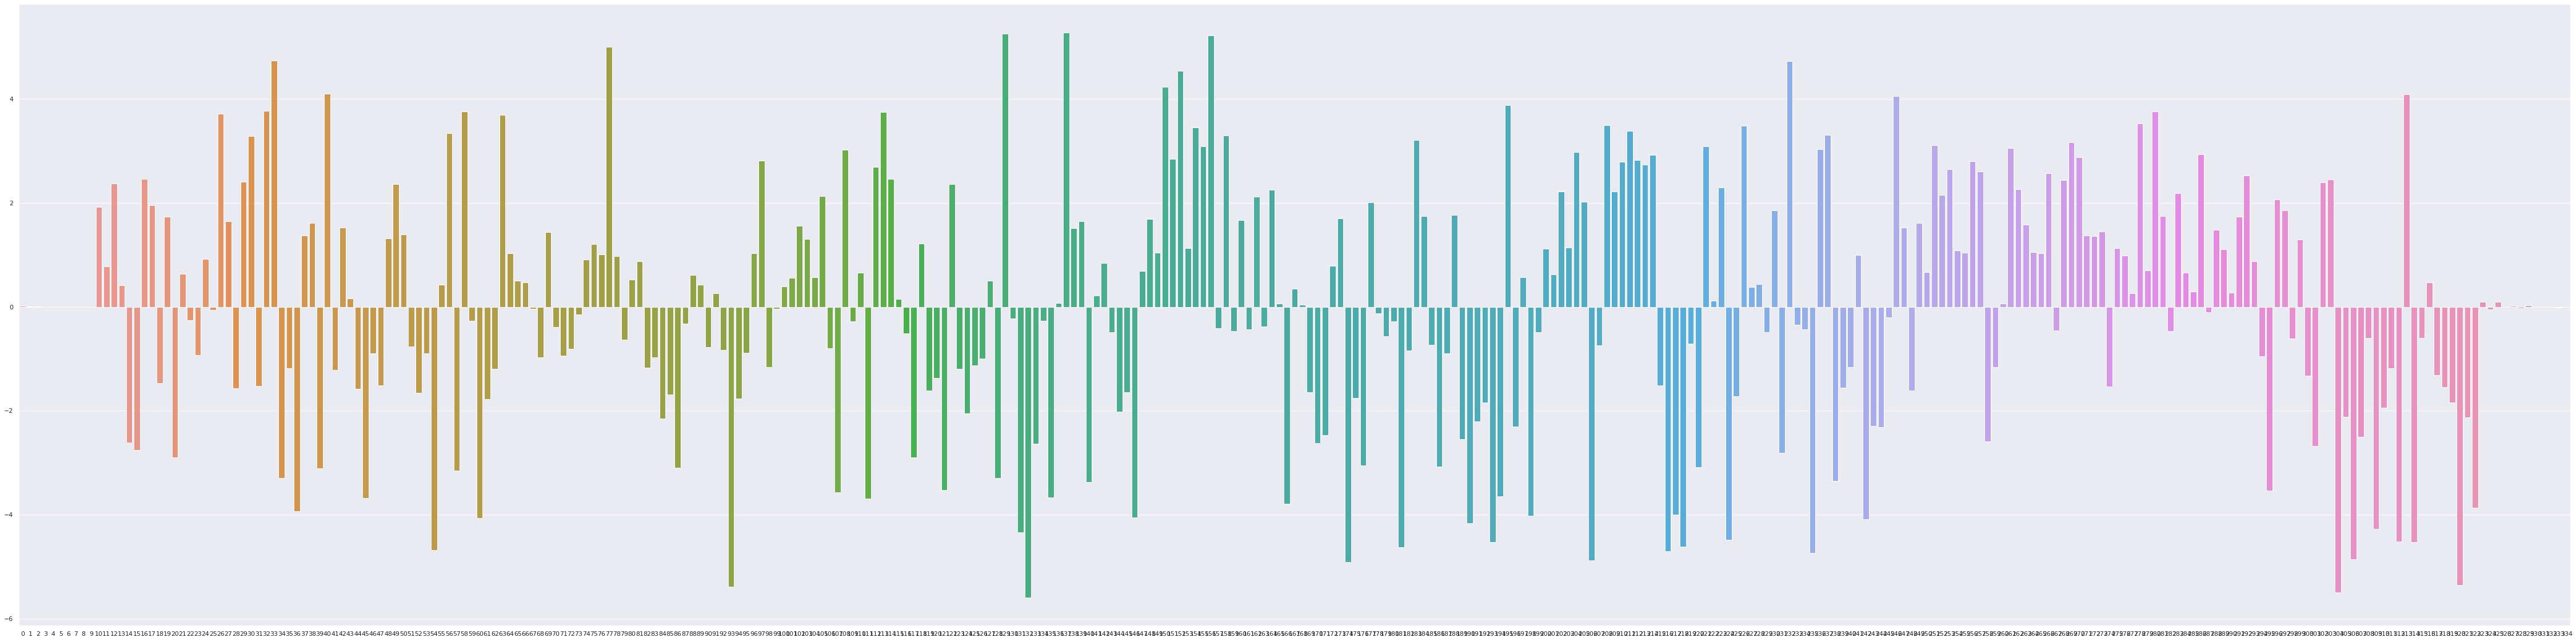

In [322]:
#Example of feature importance using linear regression model above more models found below
importance = regr.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.set(rc={'figure.figsize':(80,20)})
sns.barplot([x for x in range(len(importance))], importance)
sns.show()

In [323]:
# Make predictions using the testing set
y_pred = regr.predict(x_test)
#y_pred

y_pred

array([8.08417628, 8.10468239, 8.12952949, ..., 3.71149268, 3.72963776,
       3.77339446])

In [ ]:
#create more models

In [32]:
#create a dictionary containing all models to be used/ can be used
MODELS = OrderedDict()
MODELS["LinearRegression"]=LinearRegression()
MODELS["DecisionTree"]=DecisionTreeRegressor()
MODELS["GradientBoostingRegression"]=GradientBoostingRegressor()
MODELS["RandomForrestRegressor"]=RandomForestRegressor()
#MODELS["RidgeRegression"]=Ridge()
#MODELS["LassoRegression"]=Lasso()
#MODELS["LassoRegressionAlpha1.0"]=Lasso(alpha=1.0)
#MODELS["LassoRegressionAlpha0.5"]=Lasso(alpha=0.5)
#MODELS["LassoRegressionAlpha0.1"]=Lasso(alpha=0.5)
#MODELS["ElasticNet"]=ElasticNet()


In [33]:
#this function fits the models used above and outputs their predictions
def perform_modeling(train_X, test_X, train_y, test_y, models = MODELS):
    train_predict=pd.DataFrame(index=train_X.index)
    test_predict=pd.DataFrame(index=test_y.index)
    #Include ground truth in prediction file.
    train_predict['target']=train_y
    test_predict['target']=test_y

    #Baseline lag 1
    #baselinecol=cf['TARGET']+'_lag1'
    #print("T-1 Baseline...")
    #train_predict['baseline_lag1']=train_X[baselinecol]
    #test_predict['baseline_lag1']=test_X[baselinecol]

    trained_models=[]

    for i, (name, model) in enumerate(MODELS.items()):
        print("Fitting model: ", name )
        m = model.fit(train_X, train_y)

        train_predict[name]=m.predict(train_X)

        test_predict[name]=m.predict(test_X)
        trained_models.append({name: m})

    return train_predict, test_predict, trained_models


In [34]:
#call the function above to get the predictions for the number of confirmed cases 
x = perform_modeling(x_train,x_test,y_train_confirmed_cases,y_test_confirmed_cases,models=MODELS)


Fitting model:  LinearRegression
Fitting model:  DecisionTree
Fitting model:  GradientBoostingRegression
Fitting model:  RandomForrestRegressor


In [35]:
#assign predictions to dataframes
confirmed_cases_train_prediction_results = x[0]
confirmed_cases_test_prediction_results = x[1]

In [36]:
#replace any predictions that are negative with zero
confirmed_cases_train_prediction_results[confirmed_cases_train_prediction_results < 0] = 0
confirmed_cases_test_prediction_results[confirmed_cases_test_prediction_results < 0] = 0

In [97]:
confirmed_cases_test_prediction_results

,target,LinearRegression,DecisionTree,GradientBoostingRegression,RandomForrestRegressor
100,7.756195,6.844419,7.736307,7.776182,7.750031
101,7.811973,6.921507,7.826443,7.811306,7.827774
102,7.902857,6.989194,7.865572,7.850371,7.897547
103,7.970740,7.102415,7.967973,7.943396,7.972824
104,8.078688,7.177062,8.098035,8.089337,8.082340
...,...,...,...,...,...
35990,3.610918,5.590859,3.610918,3.639627,3.617830
35991,3.610918,5.665157,3.610918,3.639627,3.618617
35992,3.637586,5.739487,3.637586,3.671286,3.640862
35993,3.637586,5.814225,3.637586,3.639627,3.640936


In [330]:
#undo log transformation
confirmed_cases_test_prediction_results= confirmed_cases_test_prediction_results.apply(lambda x: np.expm1(x))
confirmed_cases_train_prediction_results= confirmed_cases_train_prediction_results.apply(lambda x: np.expm1(x))
confirmed_cases_test_prediction_results

,target,LinearRegression,DecisionTree,GradientBoostingRegression,RandomForrestRegressor
100,2335.0,937.871255,2289.00000,2390.050968,2326.822782
101,2469.0,1013.180207,2512.49995,2473.644575,2506.358275
102,2704.0,1084.103719,2562.00000,2575.583212,2685.444129
103,2894.0,1214.250140,2886.00000,2827.240401,2887.528815
104,3224.0,1308.491860,3287.00000,3271.553264,3219.157510
...,...,...,...,...,...
35990,36.0,267.050583,36.00000,37.099236,36.325777
35991,36.0,287.726021,36.00000,37.099236,36.326035
35992,37.0,310.006476,37.00000,38.324495,37.135601
35993,37.0,334.142798,37.00000,37.099236,37.118382


In [37]:
#add details/features back to the prediction results for the number of confirmed cases
confirmed_cases_train_prediction_results['day_number'] = train_cleaned.loc[dframe['day_number']<=99,"day_number"]
confirmed_cases_test_prediction_results['day_number'] = train_cleaned.loc[dframe['day_number']>99,"day_number"]
confirmed_cases_test_prediction_results['country_region_number'] = train_cleaned.loc[dframe['day_number']>99,"country_region_number"]
confirmed_cases_train_prediction_results['country_region_number'] = train_cleaned.loc[dframe['day_number']<=99,"country_region_number"]
confirmed_cases_test_prediction_results

,target,LinearRegression,DecisionTree,GradientBoostingRegression,RandomForrestRegressor,day_number,country_region_number
100,7.756195,6.844678,7.736307,7.779488,7.748304,100,0
101,7.811973,6.921836,7.829431,7.813852,7.824824,101,0
102,7.902857,6.989431,7.865572,7.854219,7.900194,102,0
103,7.970740,7.102705,7.961370,7.947410,7.969617,103,0
104,8.078688,7.177394,8.099858,8.093326,8.079540,104,0
...,...,...,...,...,...,...,...
35990,3.610918,5.591176,3.610918,3.640194,3.619417,110,183
35991,3.610918,5.665478,3.610918,3.640194,3.619943,111,183
35992,3.637586,5.739814,3.637586,3.671848,3.641087,112,183
35993,3.637586,5.814557,3.637586,3.640194,3.640683,113,183


In [332]:
#undo log transformation
y_test_confirmed_cases = y_test_confirmed_cases.apply(lambda x: np.expm1(x))
y_train_confirmed_cases = y_train_confirmed_cases.apply(lambda x: np.expm1(x))

y_test_confirmed_cases

100      2335.0
101      2469.0
102      2704.0
103      2894.0
104      3224.0
          ...  
35990      36.0
35991      36.0
35992      37.0
35993      37.0
35994      42.0
Name: ConfirmedCases, Length: 4695, dtype: float64

In [38]:
#Root mean square log error of the test dataset predictions for the number of confirmed cases(scores for the predictions of the last two weeks)
target_confirmed_cases_rmsle = mean_squared_log_error(y_test_confirmed_cases,confirmed_cases_test_prediction_results.target)
regression_confirmed_cases_rmsle = mean_squared_log_error(y_test_confirmed_cases,confirmed_cases_test_prediction_results.LinearRegression)
decisiontree_confirmed_cases_rmsle = mean_squared_log_error(y_test_confirmed_cases,confirmed_cases_test_prediction_results.DecisionTree)
gradientboosting_confirmed_cases_rmsle = mean_squared_log_error(y_test_confirmed_cases,confirmed_cases_test_prediction_results.GradientBoostingRegression)
randomforrest_confirmed_cases_rmsle = mean_squared_log_error(y_test_confirmed_cases,confirmed_cases_test_prediction_results.RandomForrestRegressor)

models = confirmed_cases_test_prediction_results.columns
test_scores = [regression_confirmed_cases_rmsle,decisiontree_confirmed_cases_rmsle,gradientboosting_confirmed_cases_rmsle,randomforrest_confirmed_cases_rmsle]
results = pd.DataFrame
#results['models'] = models
#results['scores'] = scores
test_scores

[0.08042065891102151,
 8.885861739760555e-06,
 3.845435900637257e-05,
 5.07597922609417e-06]

In [39]:
#Root mean square log error of the train dataset predictions for the number of confirmed cases(scores for the predictions of all days before the last two weeks)
target_confirmed_cases_rmsle = mean_squared_log_error(y_train_confirmed_cases,confirmed_cases_train_prediction_results.target)
regression_confirmed_cases_rmsle = mean_squared_log_error(y_train_confirmed_cases,confirmed_cases_train_prediction_results.LinearRegression)
decisiontree_confirmed_cases_rmsle = mean_squared_log_error(y_train_confirmed_cases,confirmed_cases_train_prediction_results.DecisionTree)
gradientboosting_confirmed_cases_rmsle = mean_squared_log_error(y_train_confirmed_cases,confirmed_cases_train_prediction_results.GradientBoostingRegression)
randomforrest_confirmed_cases_rmsle = mean_squared_log_error(y_train_confirmed_cases,confirmed_cases_train_prediction_results.RandomForrestRegressor)

models = confirmed_cases_test_prediction_results.columns
train_scores = [regression_confirmed_cases_rmsle,decisiontree_confirmed_cases_rmsle,gradientboosting_confirmed_cases_rmsle,randomforrest_confirmed_cases_rmsle]
train_scores

[0.22779357911177714,
 1.2701543547635725e-11,
 0.003982425618933323,
 0.00045207019957838783]

In [104]:
confirmed_cases_test_prediction_results

,target,LinearRegression,DecisionTree,GradientBoostingRegression,RandomForrestRegressor,day_number,country_region_number
100,2335.0,937.628080,2289.0,2382.158052,2320.644009,100,0
101,2469.0,1012.846637,2505.0,2467.350869,2508.337898,101,0
102,2704.0,1083.846886,2605.0,2565.685404,2689.673434,102,0
103,2894.0,1213.897616,2886.0,2815.911165,2900.037833,103,0
104,3224.0,1308.056661,3287.0,3258.525078,3235.800077,104,0
...,...,...,...,...,...,...,...
35990,36.0,266.965759,36.0,37.077643,36.256652,110,183
35991,36.0,287.633155,36.0,37.077643,36.285954,111,183
35992,37.0,309.904865,37.0,38.302413,37.124702,112,183
35993,37.0,334.031564,37.0,37.077643,37.127519,113,183


In [40]:
#find the total number of predicted confirmed cases for the last two weeks and plot to compare to the expected values
confirmed_cases_gradientboost_total = confirmed_cases_test_prediction_results.groupby(['day_number']).agg({'GradientBoostingRegression':['sum']})
confirmed_cases_linregression_total = confirmed_cases_test_prediction_results.groupby(['day_number']).agg({'LinearRegression':['sum']})
confirmed_cases_decisiontree_total = confirmed_cases_test_prediction_results.groupby(['day_number']).agg({'DecisionTree':['sum']})
confirmed_cases_randomforrest_total = confirmed_cases_test_prediction_results.groupby(['day_number']).agg({'RandomForrestRegressor':['sum']})

confirmed_cases_actl_total = confirmed_cases_test_prediction_results.groupby(['day_number']).agg({'target':['sum']})
#fatalities_total = train.groupby(['Date']).agg({'Fatalities':['sum']})
cases_date = confirmed_cases_actl_total.join([confirmed_cases_linregression_total,confirmed_cases_gradientboost_total,confirmed_cases_decisiontree_total,confirmed_cases_randomforrest_total])
cases_date

,target,LinearRegression,GradientBoostingRegression,DecisionTree,RandomForrestRegressor
,sum,sum,sum,sum,sum
day_number,,,,,
100,2088.639268,2205.485873,2091.051321,2088.448615,2088.718210
101,2096.406569,2235.185856,2098.583910,2096.991387,2097.085562
102,2101.930084,2260.122003,2104.140945,2102.518375,2102.753634
103,2108.910991,2283.276198,2111.447046,2109.183230,2109.586539
104,2116.904997,2304.310680,2119.530013,2117.546972,2116.965065
105,2123.841366,2327.260684,2126.367688,2124.163381,2124.330169
106,2131.769556,2356.834078,2133.505872,2132.087913,2132.348837
107,2139.871112,2384.234584,2143.017424,2140.218803,2140.543724


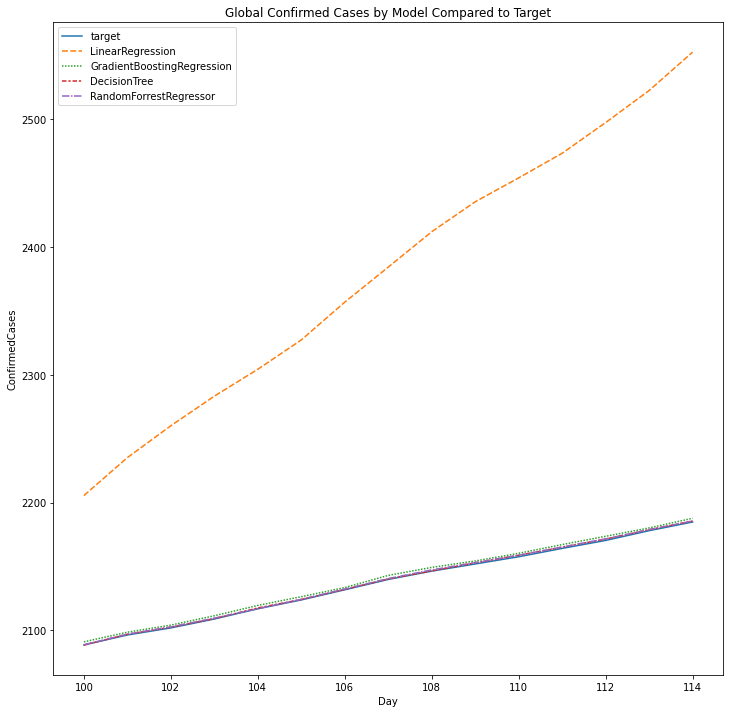

In [51]:
plt.figure(figsize=(12, 12))
plt.xlabel('Day')
plt.ylabel('ConfirmedCases')
plt.title('Global Confirmed Cases by Model Compared to Target')
sns.lineplot(data=cases_date)

In [ ]:
pd.set_option('display.max_rows', None)
#result = pd.concat([confirmed_cases_train_prediction_results, confirmed_cases_test_prediction_results])
#result = pd.merge(confirmed_cases_train_prediction_results, confirmed_cases_test_prediction_results,on='country_region_number',how='inner')

### Fatalities Modeling

In [42]:
#call modeling equation to forecast FATALITIES instead of confirmed cases
y = perform_modeling(x_train,x_test,y_train_fatalities,y_test_fatalities,models=MODELS)

#assign the predictions for the confirmed cases for both train and test to their own dataframes
#output of different models shown below 

#fatalities_test_prediction_results



Fitting model:  LinearRegression
Fitting model:  DecisionTree
Fitting model:  GradientBoostingRegression
Fitting model:  RandomForrestRegressor


In [43]:
#assign prediction results to dataframes
fatalities_train_prediction_results = y[0]
fatalities_test_prediction_results = y[1]

In [232]:
fatalities_train_prediction_results

,target,LinearRegression,DecisionTree,GradientBoostingRegression,RandomForrestRegressor
0,0.000000,-0.475915,0.000000,0.057399,0.000000
1,0.000000,-0.445012,0.000000,0.057399,0.000000
2,0.000000,-0.414110,0.000000,0.057399,0.000000
3,0.000000,-0.383207,0.000000,0.057399,0.000000
4,0.000000,-0.352304,0.000000,0.057399,0.000000
...,...,...,...,...,...
35975,1.609438,1.861380,1.609438,0.799628,1.609030
35976,1.609438,1.892061,1.609438,0.809570,1.598281
35977,1.609438,1.923035,1.609438,0.799628,1.528150
35978,1.609438,1.953640,1.609438,0.740558,1.447269


In [233]:
#undo log transformation for the target fatalities values
y_test_fatalities = y_test_fatalities.apply(lambda x: np.expm1(x))
y_train_fatalities = y_train_fatalities.apply(lambda x: np.expm1(x))

In [44]:
#replace any fatalities predictions below 0 with 0
fatalities_train_prediction_results[fatalities_train_prediction_results < 0] = 0
fatalities_test_prediction_results[fatalities_test_prediction_results < 0] = 0

In [341]:
#undo log transformation for the fatalities prediction values
fatalities_test_prediction_results= fatalities_test_prediction_results.apply(lambda x: np.expm1(x))
fatalities_train_prediction_results= fatalities_train_prediction_results.apply(lambda x: np.expm1(x))

In [45]:
fatalities_test_prediction_results

,target,LinearRegression,DecisionTree,GradientBoostingRegression,RandomForrestRegressor
100,4.234107,2.837819,4.174387,4.407704,4.545475
101,4.290459,2.874116,4.795791,4.595190,4.713877
102,4.454347,2.904611,4.927254,4.695770,4.717079
103,4.510860,2.970218,4.969813,4.757458,4.837881
104,4.564348,3.005585,4.969813,4.740916,4.891270
...,...,...,...,...,...
35990,1.609438,2.324615,1.386294,0.775132,1.397229
35991,1.609438,2.355369,1.609438,0.716062,1.376435
35992,1.609438,2.386151,1.609438,0.809570,1.410447
35993,1.609438,2.417264,1.609438,0.786437,1.326690


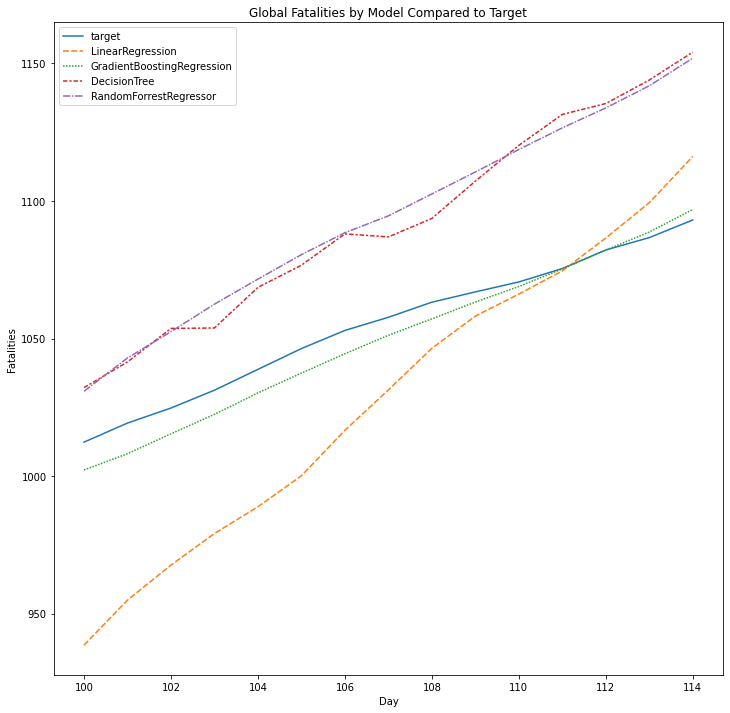

In [52]:
#add details/features back to the prediction results
fatalities_train_prediction_results['day_number'] = train_cleaned.loc[dframe['day_number']<=99,"day_number"]
fatalities_test_prediction_results['day_number'] = train_cleaned.loc[dframe['day_number']>99,"day_number"]
fatalities_test_prediction_results['country_region_number'] = train_cleaned.loc[dframe['day_number']>99,"country_region_number"]
fatalities_train_prediction_results['country_region_number'] = train_cleaned.loc[dframe['day_number']<=99,"country_region_number"]

#Root mean square log error of the test dataset predictions for the number of fatalities (scores for the predictions of the last two weeks)
target_fatalities_rmsle = mean_squared_log_error(y_test_fatalities,fatalities_test_prediction_results.target)
regression_fatalities_rmsle = mean_squared_log_error(y_test_fatalities,fatalities_test_prediction_results.LinearRegression)
decisiontree_fatalities_rmsle = mean_squared_log_error(y_test_fatalities,fatalities_test_prediction_results.DecisionTree)
gradientboosting_fatalities_rmsle = mean_squared_log_error(y_test_fatalities,fatalities_test_prediction_results.GradientBoostingRegression)
randomforrest_fatalities_rmsle = mean_squared_log_error(y_test_fatalities,fatalities_test_prediction_results.RandomForrestRegressor)

#get test scores for fatalities
models = fatalities_test_prediction_results.columns
fatalities_test_scores = [regression_fatalities_rmsle,decisiontree_fatalities_rmsle,gradientboosting_fatalities_rmsle,randomforrest_fatalities_rmsle]
results = pd.DataFrame
#results['models'] = models
#results['scores'] = scores
fatalities_test_scores

#Root mean square log error of the train dataset predictions for the number of fatalities (scores for the predictions of all days before the last two weeks)
target_fatalities_rmsle = mean_squared_log_error(y_train_fatalities,fatalities_train_prediction_results.target)
regression_fatalities_rmsle = mean_squared_log_error(y_train_fatalities,fatalities_train_prediction_results.LinearRegression)
decisiontree_fatalities_rmsle = mean_squared_log_error(y_train_fatalities,fatalities_train_prediction_results.DecisionTree)
gradientboosting_fatalities_rmsle = mean_squared_log_error(y_train_fatalities,fatalities_train_prediction_results.GradientBoostingRegression)
randomforrest_fatalities_rmsle = mean_squared_log_error(y_train_fatalities,fatalities_train_prediction_results.RandomForrestRegressor)

models = confirmed_cases_test_prediction_results.columns
fatalities_train_scores = [regression_fatalities_rmsle,decisiontree_fatalities_rmsle,gradientboosting_fatalities_rmsle,randomforrest_fatalities_rmsle]
fatalities_train_scores

#find the total number of predicted fatalities for the last two weeks and plot to compare to the expected values
fatalities_gradientboost_total = fatalities_test_prediction_results.groupby(['day_number']).agg({'GradientBoostingRegression':['sum']})
fatalities_linregression_total = fatalities_test_prediction_results.groupby(['day_number']).agg({'LinearRegression':['sum']})
fatalities_decisiontree_total = fatalities_test_prediction_results.groupby(['day_number']).agg({'DecisionTree':['sum']})
fatalities_randomforrest_total = fatalities_test_prediction_results.groupby(['day_number']).agg({'RandomForrestRegressor':['sum']})

fatalities_actl_total = fatalities_test_prediction_results.groupby(['day_number']).agg({'target':['sum']})
#fatalities_total = train.groupby(['Date']).agg({'Fatalities':['sum']})
fatalities_date = fatalities_actl_total.join([fatalities_linregression_total,fatalities_gradientboost_total,fatalities_decisiontree_total,fatalities_randomforrest_total])
fatalities_date

#plot results
plt.figure(figsize=(12, 12))
plt.xlabel('Day')
plt.ylabel('Fatalities')
plt.title('Global Fatalities by Model Compared to Target')
sns.lineplot(data=fatalities_date)

In [48]:
fatalities_test_scores

[0.23756390415341805,
 0.0444513646291165,
 0.07264975076042088,
 0.030857871389979055]